In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
from scipy.spatial import cKDTree

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

In [2]:
ds = xr.open_dataset('/data/harish/RTMA/orog/rtma/20180101/subset_0def795e__rtma2p5.t05z.2dvaranl_ndfd.grb2_wexp',
                     engine="cfgrib",backend_kwargs={'indexpath': ''})

nx, ny = 288, 256
x_start, x_end = 1800, 1800 + nx
y_start, y_end = 830, 830 + ny

ds_subset = ds.orog.isel(y=slice(y_start,y_end),x=slice(x_start,x_end)).drop_vars(['time','step','surface','valid_time'])
ds_subset.to_netcdf('orography.nc')

In [14]:
def map_plotter(fig,gs,data,x,y,levels,cmap,title,shrink,colorbar,cbar_label,orientation,extent=None,rectangles=None,sample_points=None,fontsize=None,pad=None):    
    ax = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    ax.coastlines()
    
    contour = data.plot.contourf(
        x=x,y=y,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':fontsize},
        ax=ax)
    
    # Add colorbar with font size
    if colorbar:
        cbar = fig.colorbar(contour, orientation=orientation, shrink=shrink, aspect=40, label=cbar_label,pad=pad)
        cbar.ax.tick_params(labelsize=fontsize)
        if orientation == 'horizontal':
            cbar.ax.set_xlabel(cbar_label, fontsize=fontsize)
            cbar.ax.xaxis.set_label_position('top')
        else:
            cbar.ax.set_ylabel(cbar_label, fontsize=fontsize)
            cbar.ax.yaxis.set_label_position('left')
            
    
    if extent:
        # Set the extent (for example, bounding box for Europe)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Set x and y ticks font size
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    
    # set title
    ax.set_title(title,fontsize=fontsize)
    
    # Add land feature with grey color
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'
    )
    #ax.add_feature(land_feature)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    # Add country borders
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    # Add U.S. state boundaries
    ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5, edgecolor='black')  # U.S. state boundaries
    
    if sample_points:
        for label, (lat, lon) in sample_points.items():
            ax.text(lon, lat - 0.05, label, color='black', fontsize=fontsize, ha='center', va='center')
            ax.plot(lon, lat, '.', markersize=8,color='black')
    
    if rectangles:
        target_grid = {'min_lat': 41.25, 'min_lon': -9.35,'max_lat':41.8,'max_lon':-8.65}
        # Draw a rectangular boxes
        min_lon = target_grid['min_lon']
        min_lat = target_grid['min_lat']
        max_lon = target_grid['max_lon']
        max_lat = target_grid['max_lat']
        rect = matplotlib.patches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                                        linestyle='--', linewidth=1, edgecolor='red', facecolor='none',zorder=10)
        ax.add_patch(rect)
        
    return ax

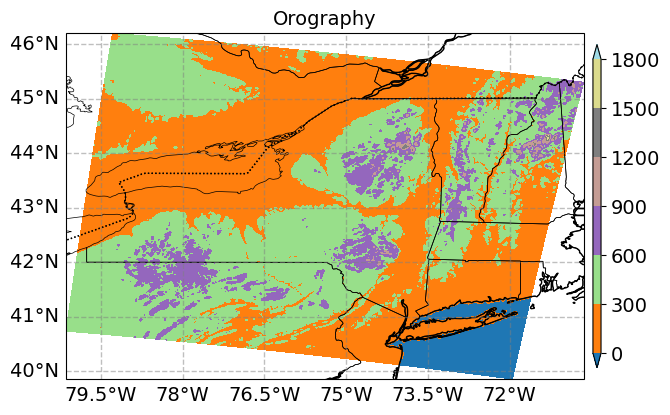

In [31]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(1,1)

map_plotter(fig,gs[0,0],ds_subset,x='longitude',y='latitude',levels=np.arange(0,40.1,5),cmap='tab20',
                title=f'Orography',shrink=0.7,colorbar=True,cbar_label='m',
                orientation='vertical',fontsize=14,pad=0.015)
plt.savefig('orography.pdf',bbox_inches='tight',dpi=300)

In [2]:
'''
# In main zarr, the latitude and longitude coorinates were not set properly at the zarr initiation. 
# They are set here. 
zarr_store = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr'
ds = xr.open_zarr(zarr_store)

# Load the lat/lon you want to insert (must match shape)
orography = xr.open_dataset("orography.nc")
lat = orography.latitude
lon = orography.longitude

# ✅ Assign coordinates
ds = ds.assign_coords({
    "latitude": lat,
    "longitude": lon
})

ds.to_zarr(zarr_store, mode="r+", consolidated=True)
'''

'\n# In main zarr, the latitude and longitude coorinates were not set properly at the zarr initiation. \n# They are set here. \nzarr_store = \'/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr\'\nds = xr.open_zarr(zarr_store)\n\n# Load the lat/lon you want to insert (must match shape)\norography = xr.open_dataset("orography.nc")\nlat = orography.latitude\nlon = orography.longitude\n\n# ✅ Assign coordinates\nds = ds.assign_coords({\n    "latitude": lat,\n    "longitude": lon\n})\n\nds.to_zarr(zarr_store, mode="r+", consolidated=True)\n'

# Read Orography and New York shp file. Create mask

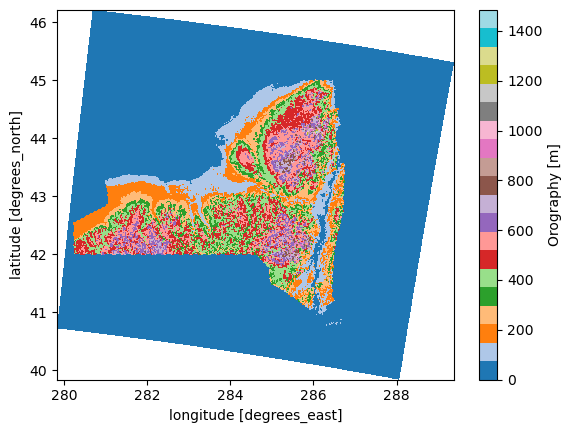

In [2]:
import geopandas as gpd
from shapely.geometry import Point

bndry_file = '110m_cultural/ne_110m_admin_1_states_provinces.shp'
states     = gpd.read_file(bndry_file)
ny_state   = states[states['name'] == "New York"]
ny_bndry   = ny_state.geometry.iloc[0]

# Flatten lat/lon from orography
orography = xr.open_dataset('orography.nc')
# The orography longitude is in the range [0, 360], while the same in shp file is in the range [-180, 180]
# Convert to [-180, 180]
lon_flat = (orography.longitude.values.ravel()+180)%360 - 180
lat_flat = orography.latitude.values.ravel()

# Create a list of shapely Point objects from grid
points = [Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)]

# Check which points are inside NY boundary
inside = np.array([ny_bndry.contains(point) for point in points])

# Reshape to 2D mask matching dmy
mask_2d = inside.reshape(orography.orog.shape)
mask_2d = xr.DataArray(mask_2d, coords = orography.coords,name='mask')
mask_2d.to_netcdf('mask_2d.nc')

# Apply mask
dmy_masked = orography.orog.where(mask_2d,0)

# Plot
dmy_masked.plot(x='longitude', y='latitude', cmap='tab20')

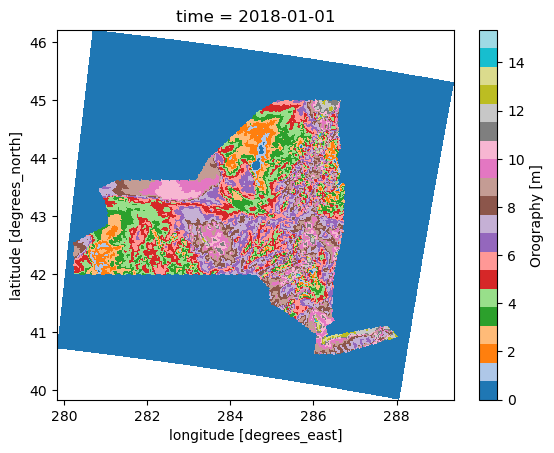

In [5]:
zarr_store = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr'
ds = xr.open_zarr(zarr_store)
sample = ds['i10fg'].isel(time=0)
mask_2d = xr.open_dataset('mask_2d.nc').mask
sample.where(mask_2d,0).plot(x='longitude', y='latitude', cmap='tab20')

In [6]:
nysm_locations = pd.read_csv('nysm.csv')
# Create an xarray Dataset with station IDs as the dimension
# Remember, the RTMA longitude is in 0 to 360, while the nysm longitude is in -180 to 180
# Convert nysm longitude to 0 to 360
nysm_ds = xr.Dataset({
    'latitude': xr.DataArray(nysm_locations['lat [degrees]'].values, dims='stations', coords={'stations': nysm_locations['stid']}),
    'longitude': xr.DataArray((nysm_locations['lon [degrees]'].values + 360)%360, dims='stations', coords={'stations': nysm_locations['stid']})
})
nysm_ds

<xarray.Dataset> Size: 3kB
Dimensions:    (stations: 126)
Coordinates:
  * stations   (stations) object 1kB 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
Data variables:
    latitude   (stations) float64 1kB 42.04 42.18 43.02 ... 43.49 43.23 42.86
    longitude  (stations) float64 1kB 282.8 285.2 281.9 ... 286.6 283.2 282.2

In [7]:
def find_nearest_indice(ds_lat,ds_lon,target_lat=None, target_lon=None):
    '''
    ds_lat: xarray DataArray of latitude
    ds_lon: xarray DataArray of longitude
    target_lat: float, target latitude
    target_lon: float, target longitude
    returns indices: tuple of indices of the nearest grid point
    '''
    distance_squared = (ds_lat - target_lat)**2 + (ds_lon - target_lon)**2
    indices = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    #print(f'Closest indices in the order of latitude (y) and longitude (x) are : {indices}')
    return indices

In [8]:
indices = [
    find_nearest_indice(sample.latitude, sample.longitude, lat.item(), lon.item())
    for lat, lon in zip(nysm_ds.latitude, nysm_ds.longitude)
]
# Split the list of tuples into separate lists for y and x indices
y_indices, x_indices = zip(*indices)
sample_ys = xr.DataArray(np.array(y_indices), dims="points")
sample_xs = xr.DataArray(np.array(x_indices), dims="points")

sample.isel(y=sample_ys, x=sample_xs)

<xarray.DataArray 'i10fg' (points: 126)> Size: 504B
dask.array<vindex-merge, shape=(126,), dtype=float32, chunksize=(126,), chunktype=numpy.ndarray>
Coordinates:
    latitude   (points) float64 1kB dask.array<chunksize=(126,), meta=np.ndarray>
    longitude  (points) float64 1kB dask.array<chunksize=(126,), meta=np.ndarray>
    time       datetime64[ns] 8B 2018-01-01
Dimensions without coordinates: points
Attributes: (12/34)
    GRIB_DxInMetres:                          2539.703
    GRIB_DyInMetres:                          2539.703
    GRIB_LaDInDegrees:                        25.0
    GRIB_Latin1InDegrees:                     25.0
    GRIB_Latin2InDegrees:                     25.0
    GRIB_LoVInDegrees:                        265.0
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               m
    GRIB_uvRelativeToGrid:                    1
    long_name:                                Orography
    standard_name:                            geopotential_height
    units:                                    m

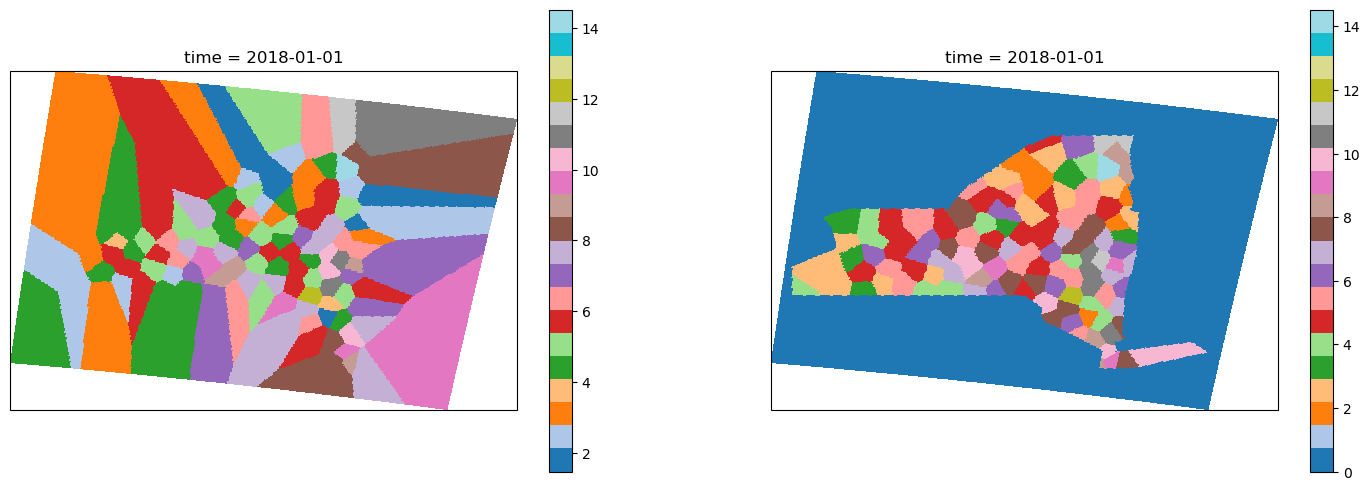

In [14]:
from scipy.interpolate import griddata
dmy = griddata((nysm_ds.latitude.values,nysm_ds.longitude.values), 
         sample.isel(y=sample_ys, x=sample_xs).values, 
         (sample.latitude, sample.longitude), method='nearest')
dmy = xr.DataArray(dmy, dims=sample.dims, coords=sample.coords)
fig, ax = plt.subplots(1,2,figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
dmy.plot(
    x='longitude', y='latitude',
    cmap='tab20',ax=ax[0],
)
dmy.where(mask_2d,0).plot(
    x='longitude', y='latitude',
    cmap='tab20',ax=ax[1],
)

# Put them in a single function for data processing

In [59]:
from scipy.interpolate import griddata

orography = xr.open_dataset('orography.nc').orog
zarr_store = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr'
variable = 'i10fg'
ds = xr.open_zarr(zarr_store)[variable]
output = ds.isel(time=0)

nysm_locations = pd.read_csv('nysm.csv')
# Create an xarray Dataset with station IDs as the dimension
# Remember, the RTMA longitude is in 0 to 360, while the nysm longitude is in -180 to 180
# Convert nysm longitude to 0 to 360
nysm_ds = xr.Dataset({
    'latitude': xr.DataArray(nysm_locations['lat [degrees]'].values, dims='stations', coords={'stations': nysm_locations['stid']}),
    'longitude': xr.DataArray((nysm_locations['lon [degrees]'].values + 360)%360, dims='stations', coords={'stations': nysm_locations['stid']})
})

from scipy.spatial import cKDTree

# Flatten the grid
lat_flat = output.latitude.values.ravel()
lon_flat = output.longitude.values.ravel()
grid_points = np.stack([lat_flat, lon_flat], axis=-1)

tree = cKDTree(grid_points)

# Query the station locations
station_points = np.stack([nysm_ds.latitude.values, nysm_ds.longitude.values], axis=-1)
_, indices_flat = tree.query(station_points)

# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, output.latitude.shape)
y_indices = xr.DataArray(np.array(y_indices), dims="points")
x_indices = xr.DataArray(np.array(x_indices), dims="points")

input = griddata((nysm_ds.latitude.values,nysm_ds.longitude.values), 
         output.isel(y=y_indices, x=x_indices).values, 
         (output.latitude, output.longitude), method='nearest')
input = xr.DataArray(input, dims=sample.dims, coords=sample.coords)

# concat input and orography
input = xr.concat([input, orography], dim='chnl')

# apply mask
mask_2d = xr.open_dataset('mask_2d.nc').mask
input = input.where(mask_2d,0)
output = output.where(mask_2d,0)

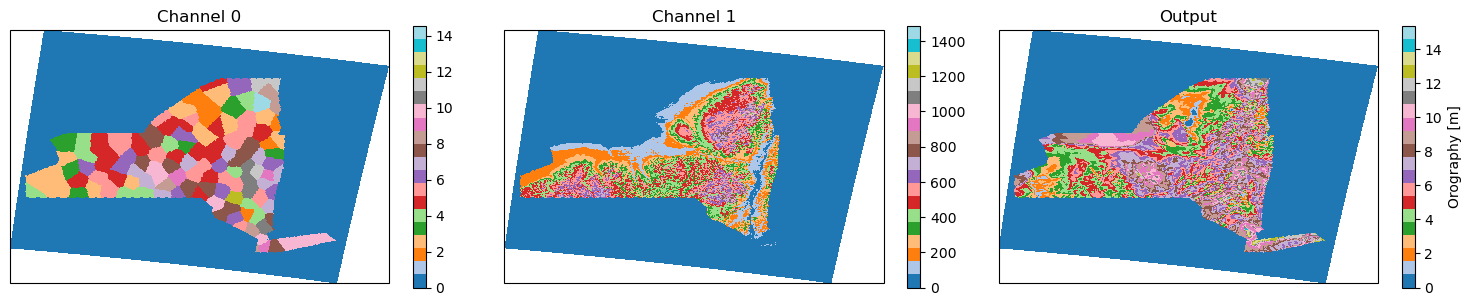

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the first channel (chnl=0)
input.sel(chnl=0).plot(ax=axes[0], x='longitude', y='latitude', cmap='tab20', add_colorbar=True)
axes[0].set_title('Channel 0')

# Plot the second channel (chnl=1)
input.sel(chnl=1).plot(ax=axes[1], x='longitude', y='latitude', cmap='tab20', add_colorbar=True)
axes[1].set_title('Channel 1')

# Plot the output
output.plot(ax=axes[2], x='longitude', y='latitude', cmap='tab20', add_colorbar=True)
axes[2].set_title('Output')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

orography = xr.open_dataset('orography.nc').orog
RTMA_lat = orography.latitude.values
RTMA_lon = orography.longitude.values

mask = xr.open_dataset('mask_2d.nc').mask
# Load NYSM station data
nysm = pd.read_csv('nysm.csv')
# NYSM station lat/lon
nysm_latlon = np.stack([
    nysm['lat [degrees]'].values,
    (nysm['lon [degrees]'].values + 360) % 360
], axis=-1)

# Precompute grid KDTree
grid_points = np.stack([RTMA_lat.ravel(), RTMA_lon.ravel()], axis=-1)
tree = cKDTree(grid_points)
# Query the station locations
_, indices_flat = tree.query(nysm_latlon)
# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, orography.shape)

# === Put this in Dataset function ===
# Precomputed Inputs: orography, RTMA_lat, RTMA_lon, nysm_latlon, y_indices, x_indices, mask
# 

zarr_store = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr'
variable = 'i10fg'
ds = xr.open_zarr(zarr_store)[variable]
output = ds.isel(time=0)

# Grab station values from output
station_values = output.values[y_indices, x_indices]

# Interpolate station values to full grid
interp = griddata(
    nysm_latlon,
    station_values,
    (RTMA_lat, RTMA_lon),
    method='nearest'
)

# Combine inputs: interpolated + orography
input_tensor = np.stack([interp, orography.values], axis=0)  # shape: [2, y, x]

# Apply mask
input_tensor = np.where(mask, input_tensor, 0)
target_tensor = np.where(mask, output.values, 0)

# Findind missing time instances

In [ ]:
zarr_store = '/data/harish/Sparse_to_dense_meteorological_variables/RTMA.zarr'
ds = xr.open_zarr(zarr_store)
variable = 'i10fg'
nan_times = ds[variable].isnull().any(dim=['y','x'])
nan_times = ds["time"].where(nan_times).dropna(dim="time").load()
# save nan times to netcdf
nan_times.to_netcdf(f'nan_times_{variable}.nc')